In [2]:
import pandas as pd
import numpy as np

# Направленность метрик в экспериментах
Создадим корпус с 1000 экспериментами и 10 метриками. У каждой метрики будет lift и pvalue. Потом найдем прокси метрики с помощью направленности

In [4]:
exp_list = []
exp_len = 1000
metric_list = [f"""metric_{i}""" for i in range(0,10)]

for id in range(0, exp_len):

    df = pd.DataFrame({
        "exp_id": id,
        "metric": metric_list,
        "lift": np.random.uniform(-0.1, 0.1, len(metric_list)),
        "statistic": np.random.normal(0, 1, len(metric_list))
    })

    exp_list.append(df)

exp_res = pd.concat(exp_list)
exp_res


,exp_id,metric,lift,statistic
0,0,metric_0,0.088251,0.018443
1,0,metric_1,-0.018109,1.061358
2,0,metric_2,0.037386,-0.051223
3,0,metric_3,-0.034061,-0.626835
4,0,metric_4,-0.025031,0.457154
...,...,...,...,...
5,999,metric_5,-0.013079,1.190459
6,999,metric_6,-0.099608,-0.171373
7,999,metric_7,0.036777,-1.503865
8,999,metric_8,-0.086083,0.695866


### Напишем функцию направленности
Сделаем простую функцию, которая будет возвращать 1 если все все условия соблюдены.
Далее нарисуем матрицу, в которую закаунтим все случаи, когда метрики были направлены и посмотрим что получается

In [48]:
def agreement(row_i, row_j, tq = 1.96):
    """Проверка направленности"""
    cond_list = [
        (row_i.lift > 0) & (row_j.lift > 0) & (abs(row_i.statistic) < tq) & (abs(row_j.statistic) < tq),
        (row_i.lift < 0) & (row_j.lift < 0) & (abs(row_i.statistic) < tq) & (abs(row_j.statistic) < tq),
        (row_i.lift == 0) & (row_j.lift == 0) & (abs(row_i.statistic) < tq) & (abs(row_j.statistic) < tq)
    ]
    choice_list = [1,1,1]
    return np.select(cond_list,  choice_list, default=0)


agreements = np.zeros((10, 10))

for id in range(0, exp_len):
    df = exp_res[exp_res.exp_id == id]
    matrix = np.zeros((10, 10))

    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            matrix[i][j] = agreement(row_i, row_j)

    agreements = agreements + matrix

agreements = np.triu(agreements, k=0)

В итоге мы получили матрицу 10х10, где перебором мы сравнили все комбинации метрик. Нижнюю часть матрицы отрежем, т.к. смысла в ней нет

In [49]:
agreements

array([[959., 486., 435., 445., 463., 453., 464., 473., 460., 478.],
       [  0., 956., 427., 485., 439., 447., 463., 449., 441., 470.],
       [  0.,   0., 950., 456., 462., 471., 470., 427., 457., 481.],
       [  0.,   0.,   0., 955., 461., 471., 457., 470., 421., 435.],
       [  0.,   0.,   0.,   0., 962., 464., 478., 482., 459., 464.],
       [  0.,   0.,   0.,   0.,   0., 960., 457., 468., 463., 462.],
       [  0.,   0.,   0.,   0.,   0.,   0., 953., 443., 466., 460.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 957., 442., 463.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 953., 437.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 951.]])

В реальном мире почти никогда так не бывает, чтобы столько метрик были сонаправлены. Но т.к. данные синтетические, то задачу мы закрыли и логику можно наследовать на живые данные

Мы также можно посмотреть на корреляцию t-статистик

In [50]:
exp_res = exp_res.pivot_table(index=['exp_id'],
         columns=["metric"], values='statistic') \
.reset_index()
exp_res

metric,exp_id,metric_0,metric_1,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9
0,0,-1.702877,1.007894,0.009573,-1.861390,-0.393224,-1.917327,-0.402851,-1.646769,-1.296610,1.746661
1,1,-0.403749,-1.268092,-0.361402,0.843747,-0.519200,0.401884,-0.461870,0.813582,-1.294881,-0.861591
2,2,0.692936,-1.548943,-1.564166,-0.517027,1.248063,1.187811,-0.741904,-0.799821,0.132600,-1.697077
3,3,-1.573877,0.024292,-1.039035,-0.837083,0.021234,-0.968052,-0.957879,1.885889,-0.086603,1.347282
4,4,0.177107,-0.413591,-0.288726,0.564428,0.992174,0.945057,-0.270702,-0.570085,0.920166,0.522209
...,...,...,...,...,...,...,...,...,...,...,...
995,995,-0.031839,0.085643,-2.378144,1.175756,-0.756541,-0.002719,-0.812747,-0.802680,-0.297304,1.018119
996,996,0.387139,2.366065,-1.194559,0.898847,-1.301483,-0.320322,-0.702571,0.098366,-0.453642,-1.268141
997,997,0.215365,-0.773233,-1.091533,0.466251,1.742701,0.223225,-0.217500,-0.158167,0.360904,1.756396
998,998,1.254040,1.252588,-0.674462,-0.099342,-0.813531,-1.714062,0.434732,-1.216948,0.222183,1.783201


/Users/iskander/Documents/expf_intensive/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/iskander/Documents/expf_intensive/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/iskander/Documents/expf_intensive/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

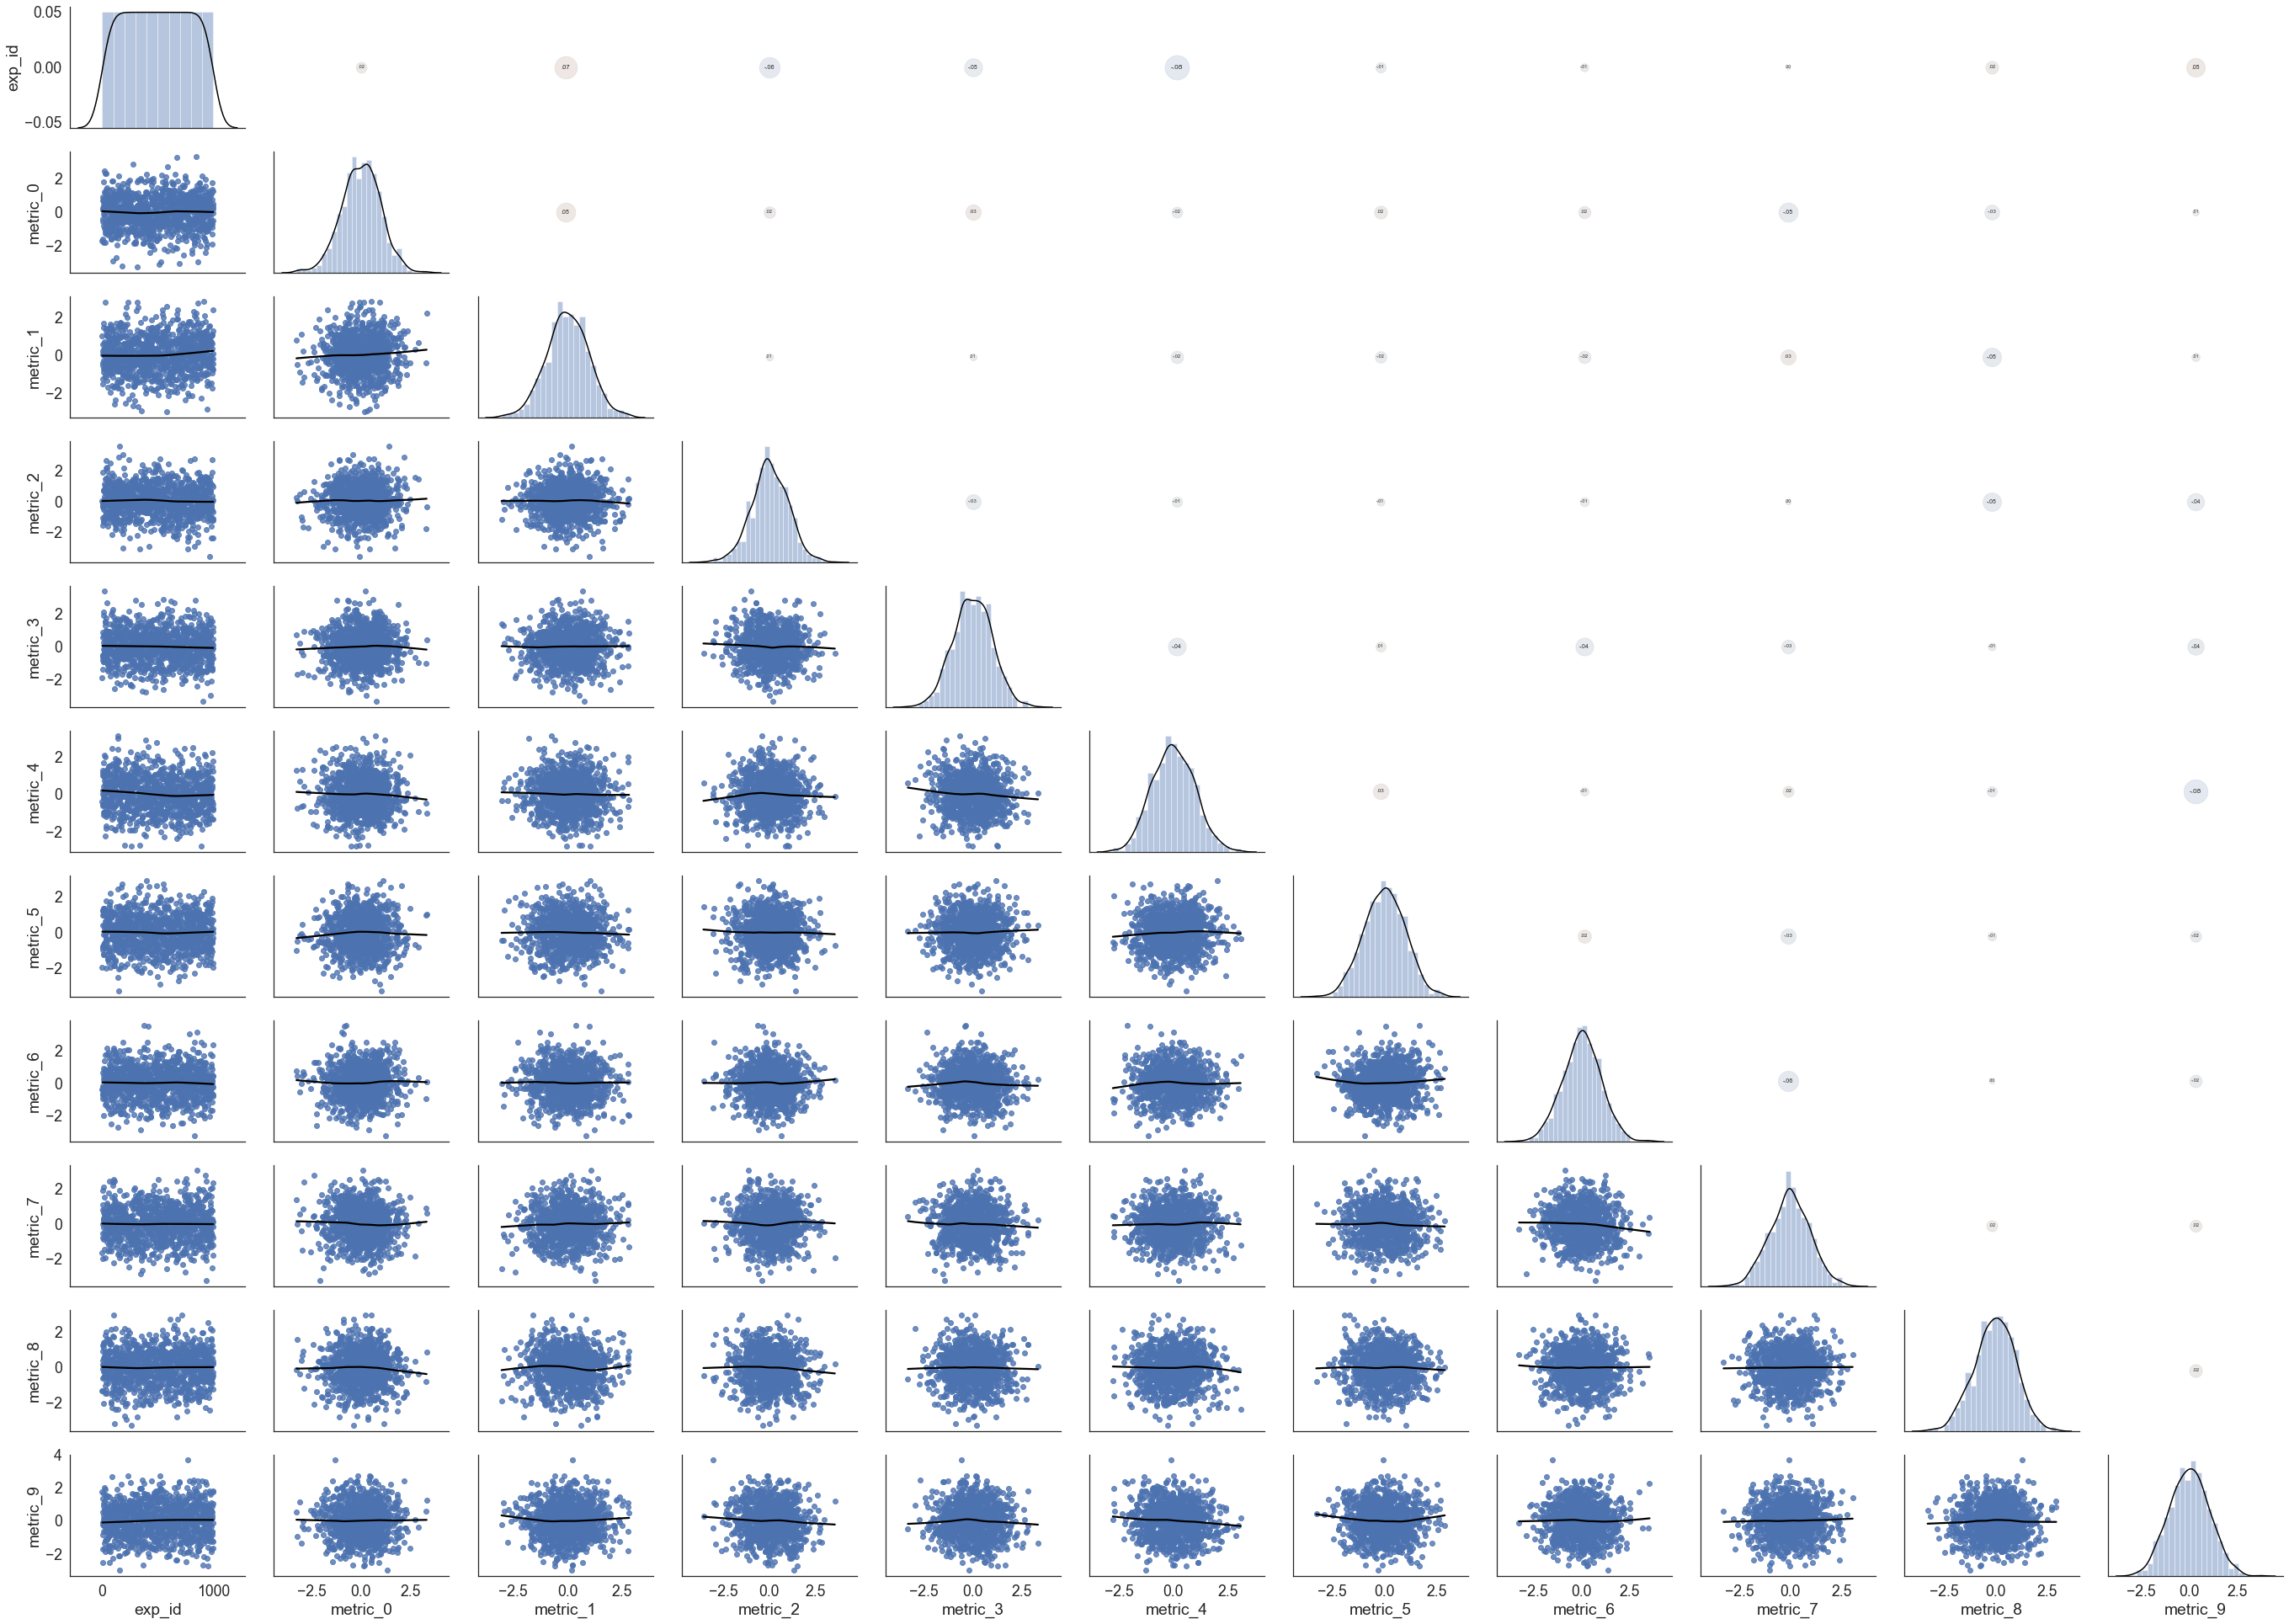

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(exp_res, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

В нашем случае ни у одной из пары метрик нет корреляции. Этот пример был показан в качестве демонстранции подхода к поиску прокси метрик. Поэтому картина на реальных данных наверняка будет отличной от графика выше.